In [ ]:
import torch


In [ ]:
torch.cuda.empty_cache()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import os
import random
import re

# Data handling
import pandas as pd
import numpy as np

# PyTorch & utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# NLP libraries
import spacy

# HuggingFace Transformers
from transformers import BertTokenizer, BertModel

# Progress bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
# Update these paths to match your actual file locations
df_a = "/content/drive/MyDrive/test_data (1).csv"
df_b = "/content/drive/MyDrive/processed_reviews_course.csv"
df_c = "/content/drive/MyDrive/processed_reviews_movies.csv"

# Load datasets
try:
    df_imdb1 = pd.read_csv(df_c)
    df_edu1 = pd.read_csv(df_b)
    df_amazon1 = pd.read_csv(df_a)
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please check your file paths and ensure files exist in Google Drive")


All datasets loaded successfully!


In [ ]:
def stratified_sample(df, label_col, n, seed=42):

    labels = df[label_col].unique()
    per_label = n // len(labels)
    sampled_dfs = []

    for label in labels:
        label_df = df[df[label_col] == label]
        if len(label_df) >= per_label:
            sampled_dfs.append(label_df.sample(n=per_label, random_state=seed))
        else:
            print(f"Warning: Not enough samples for label {label}. Using all {len(label_df)} samples.")
            sampled_dfs.append(label_df)

    return pd.concat(sampled_dfs, ignore_index=True)

# Sample datasets
df_imdb = stratified_sample(df_imdb1, 'label', 200000)
df_edu = stratified_sample(df_edu1, 'label', 200000)
df_amazon = stratified_sample(df_amazon1, 'label', 200000)


In [ ]:
print(df_imdb1.columns)
print(df_edu1.columns)
print(df_amazon1.columns)


Index(['label', 'text'], dtype='object')
Index(['label', 'text'], dtype='object')
Index(['label', 'text'], dtype='object')


In [ ]:
# Check class distributions
print("IMDB class counts:")
print(df_imdb['label'].value_counts())

print("\nEducation class counts:")
print(df_edu['label'].value_counts())

print("\nAmazon class counts:")
print(df_amazon['label'].value_counts())


IMDB class counts:
label
1    100000
2    100000
Name: count, dtype: int64

Education class counts:
label
2    100000
1    100000
Name: count, dtype: int64

Amazon class counts:
label
2    100000
1    100000
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    """
    Clean and preprocess text data
    """
    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove special characters but keep spaces
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

# Apply text cleaning
for df in [df_amazon, df_imdb, df_edu]:
    df['text'] = df['text'].apply(clean_text)

print("Text cleaning completed!")


Text cleaning completed!


In [ ]:
def split_dataset(df):
    """
    Split dataset into train/validation/test sets
    """
    train, temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    val, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['label'])
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

# Split datasets
amazon_train, amazon_val, amazon_test = split_dataset(df_amazon)
imdb_train, imdb_val, imdb_test = split_dataset(df_imdb)
edu_train, edu_val, edu_test = split_dataset(df_edu)

print("Dataset splitting completed!")
print(f"Amazon - Train: {len(amazon_train)}, Val: {len(amazon_val)}, Test: {len(amazon_test)}")
print(f"IMDB - Train: {len(imdb_train)}, Val: {len(imdb_val)}, Test: {len(imdb_test)}")
print(f"Education - Train: {len(edu_train)}, Val: {len(edu_val)}, Test: {len(edu_test)}")


Dataset splitting completed!
Amazon - Train: 160000, Val: 20000, Test: 20000
IMDB - Train: 160000, Val: 20000, Test: 20000
Education - Train: 160000, Val: 20000, Test: 20000


In [ ]:
# Install and load NLTK VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully!")
except OSError:
    print("Installing spaCy English model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


spaCy model loaded successfully!


In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def collate_fn(batch):
    return tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)

def get_bert_vectors_batch(texts, batch_size=32):
    """
    Extract BERT embeddings for a batch of texts
    """
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    all_embeddings = []
    bert_model.to(device).eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting BERT features"):
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            outputs = bert_model(**batch)
            cls_vec = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_vec.cpu().numpy())

    return np.vstack(all_embeddings)


In [ ]:
def get_lexical_features(text):
    """
    Extract lexical features using VADER sentiment analysis
    """
    scores = sid.polarity_scores(text)
    return [scores['pos'], scores['neu'], scores['neg'], scores['compound']]


In [ ]:
def get_syntactic_vectors(texts):
    """
    Extract syntactic features using spaCy
    """
    vectors = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100), total=len(texts), desc="Extracting syntactic features"):
        negation = int(any(tok.dep_ == "neg" for tok in doc))
        num_nouns = sum(1 for tok in doc if tok.pos_ == "NOUN")
        num_verbs = sum(1 for tok in doc if tok.pos_ == "VERB")
        vectors.append([negation, num_nouns, num_verbs])
    return vectors


In [ ]:
def save_feature_set(df, name):
    """
    Save extracted features to file
    """
    os.makedirs("/content/drive/MyDrive/features", exist_ok=True)

    # Ensure labels are 0-based
    labels = df['label'].to_numpy()
    if labels.min() > 0:
        labels = labels - labels.min()

    torch.save({
        'bert': np.stack(df['bert_vector'].to_numpy()),
        'lexical': np.stack(df['lexical_vector'].to_numpy()),
        'syntactic': np.stack(df['syntactic_vector'].to_numpy()),
        'labels': labels
    }, f"/content/drive/MyDrive/features/{name}_features.pt")

    print(f"Features saved for {name}")


In [ ]:
def extract_features_and_save(df, name):
    """
    Extract all features for a dataset and save them
    """
    print(f"Processing {name}...")

    # Make a copy to avoid modifying original
    df_copy = df.copy()

    # BERT features
    try:
        texts = df_copy["text"].tolist()
        print("Extracting BERT features...")
        bert_vecs = get_bert_vectors_batch(texts)
        df_copy["bert_vector"] = list(bert_vecs)
        print("BERT features extracted successfully!")
    except Exception as e:
        print(f"Error extracting BERT features for {name}: {e}")
        return False

    # Lexical features
    try:
        print("Extracting lexical features...")
        df_copy["lexical_vector"] = df_copy["text"].apply(get_lexical_features)
        print("Lexical features extracted successfully!")
    except Exception as e:
        print(f"Error extracting lexical features for {name}: {e}")
        return False

    # Syntactic features
    try:
        print("Extracting syntactic features...")
        syn_vecs = get_syntactic_vectors(df_copy["text"].tolist())
        df_copy["syntactic_vector"] = syn_vecs
        print("Syntactic features extracted successfully!")
    except Exception as e:
        print(f"Error extracting syntactic features for {name}: {e}")
        return False

    # Save features
    try:
        save_feature_set(df_copy, name)
        print(f"Features for {name} saved successfully!\n")
        return True
    except Exception as e:
        print(f"Error saving features for {name}: {e}")
        return False

# Extract features for all datasets
datasets_to_process = {
    "amazon_train": amazon_train,
    "amazon_val": amazon_val,
    "amazon_test": amazon_test,
    "imdb_test": imdb_test,
    "edu_test": edu_test
}

for name, df in datasets_to_process.items():
    success = extract_features_and_save(df, name)
    if not success:
        print(f"Failed to process {name}")
        break


Processing amazon_train...
Extracting BERT features...
Error extracting BERT features for amazon_train: name 'get_bert_vectors_batch' is not defined
Failed to process amazon_train


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

def collate_fn(batch):
    return tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)

def get_bert_vectors_batch(texts, batch_size=32):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    all_embeddings = []
    bert_model.to(device).eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            outputs = bert_model(**batch)
            cls_vec = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_vec.cpu().numpy())
    return np.vstack(all_embeddings)


In [ ]:
def get_lexical_features(text):
    scores = sid.polarity_scores(text)
    return [scores['pos'], scores['neu'], scores['neg'], scores['compound']]


In [ ]:
nlp = spacy.load("en_core_web_sm")

def get_syntactic_vectors(texts):
    vectors = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100), total=len(texts), desc="spaCy Batch"):
        negation = int(any(tok.dep_ == "neg" for tok in doc))
        num_nouns = sum(1 for tok in doc if tok.pos_ == "NOUN")
        num_verbs = sum(1 for tok in doc if tok.pos_ == "VERB")
        vectors.append([negation, num_nouns, num_verbs])
    return vectors

In [ ]:
def save_feature_set(df, name):
    os.makedirs("/content/drive/MyDrive/features", exist_ok=True)
    torch.save({
        'bert': np.stack(df['bert_vector'].to_numpy()),
        'lexical': np.stack(df['lexical_vector'].to_numpy()),
        'syntactic': np.stack(df['syntactic_vector'].to_numpy()),
        'labels': df['label'].to_numpy() - df['label'].min()  # Labels 0-based
    }, f"/content/drive/MyDrive/features/{name}_features.pt")


In [ ]:
class SentimentDatasetCNN(Dataset):
    def __init__(self, bert_tokens, lex_vecs, syn_vecs, labels):
        self.bert = bert_tokens
        self.lex = lex_vecs
        self.syn = syn_vecs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.bert[idx], dtype=torch.float),
            torch.tensor(self.lex[idx], dtype=torch.float),
            torch.tensor(self.syn[idx], dtype=torch.float),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )


In [ ]:
def load_feature_set(name):
    """
    Load pre-extracted features from file with proper weights_only setting
    """
    try:
        # Set weights_only=False to allow loading numpy arrays
        obj = torch.load(f"/content/drive/MyDrive/features/{name}_features.pt",
                        map_location='cpu', weights_only=False)
        return SentimentDatasetCNN(obj['bert'], obj['lexical'], obj['syntactic'], obj['labels'])
    except FileNotFoundError:
        print(f"Feature file for {name} not found. Please run feature extraction first.")
        return None
    except Exception as e:
        print(f"Error loading feature file for {name}: {e}")
        return None


In [ ]:
class FeatureAttentionFusionModel(nn.Module):
    def __init__(self, bert_dim, lex_dim, syn_dim, hidden_dim, num_classes):
        super().__init__()
        self.bert_proj = nn.Linear(bert_dim, hidden_dim)
        self.lex_proj = nn.Linear(lex_dim, hidden_dim)
        self.syn_proj = nn.Linear(syn_dim, hidden_dim)

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 3, 3)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, bert_vec, lex_vec, syn_vec):
        # Project all features to same dimension
        bert_feat = self.bert_proj(bert_vec)
        lex_feat = self.lex_proj(lex_vec)
        syn_feat = self.syn_proj(syn_vec)

        # Stack features for attention
        stacked = torch.stack([bert_feat, lex_feat, syn_feat], dim=1)

        # Compute attention weights
        concat = torch.cat([bert_feat, lex_feat, syn_feat], dim=1)
        attn_weights = F.softmax(self.attention(concat), dim=1).unsqueeze(2)

        # Apply attention and fuse features
        fused = torch.sum(attn_weights * stacked, dim=1)

        return self.classifier(fused)


In [ ]:

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, dataloader, optimizer, loss_fn, num_epochs=20):
    """
    Train the model
    """
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        for bert, lex, syn, label in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            bert, lex, syn, label = bert.to(device), lex.to(device), syn.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(bert, lex, syn)
            loss = loss_fn(output, label)

            # Check for invalid loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ Skipping batch due to invalid loss: {loss.item()}")
                continue

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

def evaluate_model(model, dataloader):
    """
    Evaluate model and return metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for bert, lex, syn, label in dataloader:
            bert, lex, syn = bert.to(device), lex.to(device), syn.to(device)
            output = model(bert, lex, syn)
            preds = torch.argmax(output, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return acc, precision, recall, f1, all_labels, all_preds


In [ ]:

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    # Load training dataset
    print("Loading training dataset...")
    dtrain = load_feature_set("amazon_train")

    if dtrain is None:
        raise ValueError("Failed to load training dataset")

    # Get feature dimensions from first sample
    sample_bert, sample_lex, sample_syn, sample_label = dtrain[0]
    dim_bert = sample_bert.shape[0]
    dim_lex = sample_lex.shape[0]
    dim_syn = sample_syn.shape[0]
    num_classes = len(np.unique(dtrain.labels))

    print(f"Feature dimensions:")
    print(f"  BERT: {dim_bert}")
    print(f"  Lexical: {dim_lex}")
    print(f"  Syntactic: {dim_syn}")
    print(f"  Number of classes: {num_classes}")

    # Create model
    model = FeatureAttentionFusionModel(
        bert_dim=dim_bert,
        lex_dim=dim_lex,
        syn_dim=dim_syn,
        hidden_dim=128,
        num_classes=num_classes
    ).to(device)

    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = nn.CrossEntropyLoss()

    # Create data loader
    train_loader = DataLoader(dtrain, batch_size=32, shuffle=True)
    print(f"Training loader created with {len(train_loader)} batches")

    # Training function with progress tracking
    def train_model(model, dataloader, optimizer, loss_fn, num_epochs=20):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            num_batches = 0

            for bert, lex, syn, label in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                bert, lex, syn, label = bert.to(device), lex.to(device), syn.to(device), label.to(device)

                optimizer.zero_grad()
                output = model(bert, lex, syn)
                loss = loss_fn(output, label)

                # Check for invalid loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ Skipping batch due to invalid loss: {loss.item()}")
                    continue

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

            avg_loss = total_loss / num_batches if num_batches > 0 else 0
            print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    # Start training
    print("Starting training...")
    train_model(model, train_loader, optimizer, loss_fn, num_epochs=20)

    # Save model
    torch.save(model.state_dict(), "/content/drive/MyDrive/feature_attention_model.pth")
    print("Model saved successfully!")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()


Using device: cuda
Loading training dataset...
Feature dimensions:
  BERT: 768
  Lexical: 4
  Syntactic: 3
  Number of classes: 2
Model created with 109125 parameters
Training loader created with 5000 batches
Starting training...


Epoch 1/20: 100%|██████████| 5000/5000 [00:29<00:00, 170.00it/s]


Epoch 1/20, Average Loss: 0.3124


Epoch 2/20: 100%|██████████| 5000/5000 [00:21<00:00, 228.99it/s]


Epoch 2/20, Average Loss: 0.2841


Epoch 3/20: 100%|██████████| 5000/5000 [00:20<00:00, 239.65it/s]


Epoch 3/20, Average Loss: 0.2757


Epoch 4/20: 100%|██████████| 5000/5000 [00:20<00:00, 247.74it/s]


Epoch 4/20, Average Loss: 0.2693


Epoch 5/20: 100%|██████████| 5000/5000 [00:20<00:00, 241.48it/s]


Epoch 5/20, Average Loss: 0.2649


Epoch 6/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.68it/s]


Epoch 6/20, Average Loss: 0.2609


Epoch 7/20: 100%|██████████| 5000/5000 [00:20<00:00, 241.21it/s]


Epoch 7/20, Average Loss: 0.2582


Epoch 8/20: 100%|██████████| 5000/5000 [00:21<00:00, 237.62it/s]


Epoch 8/20, Average Loss: 0.2553


Epoch 9/20: 100%|██████████| 5000/5000 [00:19<00:00, 250.69it/s]


Epoch 9/20, Average Loss: 0.2526


Epoch 10/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.29it/s]


Epoch 10/20, Average Loss: 0.2502


Epoch 11/20: 100%|██████████| 5000/5000 [00:20<00:00, 249.71it/s]


Epoch 11/20, Average Loss: 0.2479


Epoch 12/20: 100%|██████████| 5000/5000 [00:20<00:00, 240.42it/s]


Epoch 12/20, Average Loss: 0.2462


Epoch 13/20: 100%|██████████| 5000/5000 [00:20<00:00, 248.44it/s]


Epoch 13/20, Average Loss: 0.2440


Epoch 14/20: 100%|██████████| 5000/5000 [00:20<00:00, 239.47it/s]


Epoch 14/20, Average Loss: 0.2421


Epoch 15/20: 100%|██████████| 5000/5000 [00:20<00:00, 245.07it/s]


Epoch 15/20, Average Loss: 0.2401


Epoch 16/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.01it/s]


Epoch 16/20, Average Loss: 0.2382


Epoch 17/20: 100%|██████████| 5000/5000 [00:20<00:00, 238.39it/s]


Epoch 17/20, Average Loss: 0.2367


Epoch 18/20: 100%|██████████| 5000/5000 [00:20<00:00, 247.67it/s]


Epoch 18/20, Average Loss: 0.2353


Epoch 19/20: 100%|██████████| 5000/5000 [00:20<00:00, 239.15it/s]


Epoch 19/20, Average Loss: 0.2340


Epoch 20/20: 100%|██████████| 5000/5000 [00:20<00:00, 248.39it/s]


Epoch 20/20, Average Loss: 0.2324
Model saved successfully!


Loading test datasets...

Evaluating on Amazon Test...
Results for Amazon Test:
  Accuracy: 0.8947
  Precision: 0.8959
  Recall: 0.8947
  F1 Score: 0.8946

Classification Report for Amazon Test:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     10000
           1       0.92      0.87      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.90      0.89      0.89     20000
weighted avg       0.90      0.89      0.89     20000


Evaluating on IMDB Test...
Results for IMDB Test:
  Accuracy: 0.7678
  Precision: 0.7681
  Recall: 0.7678
  F1 Score: 0.7677

Classification Report for IMDB Test:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     10000
           1       0.78      0.75      0.76     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.7

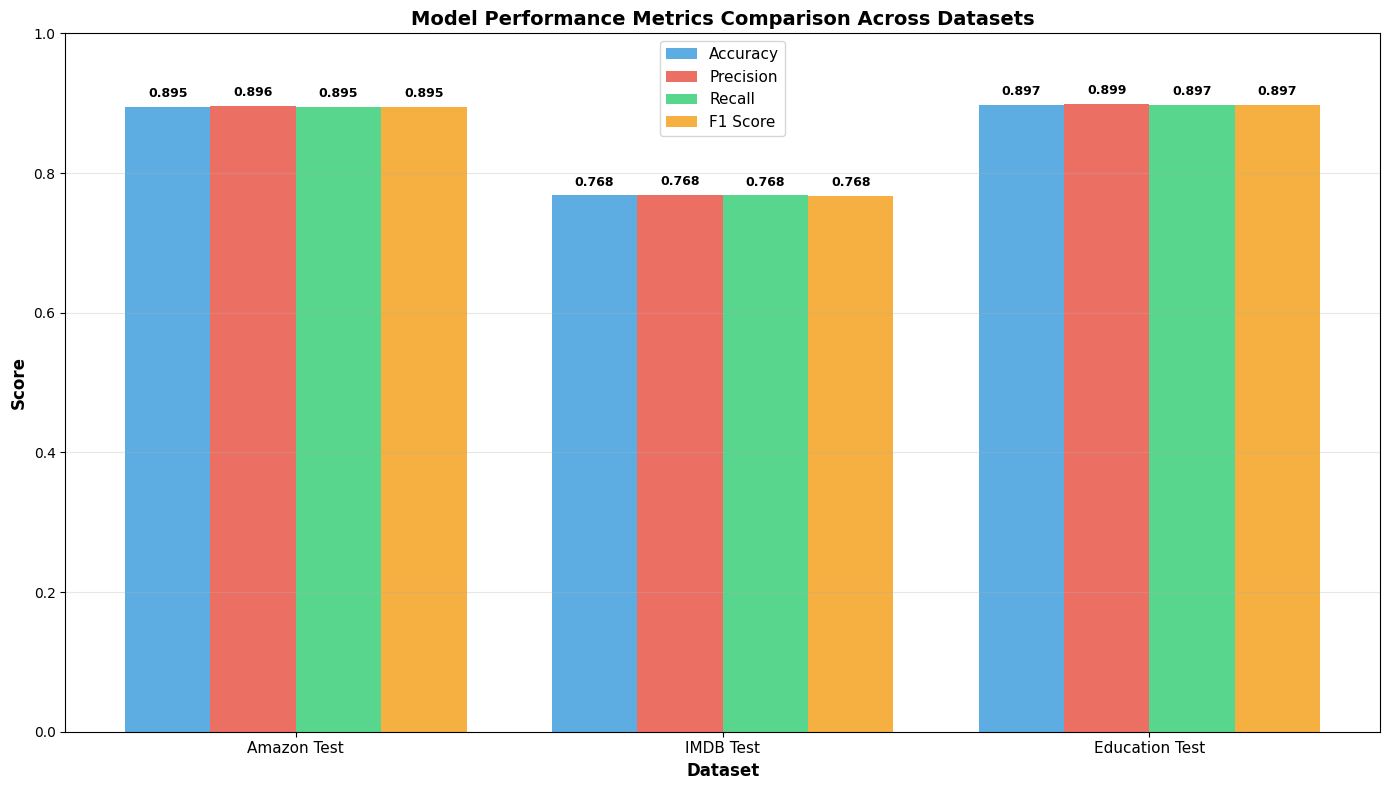

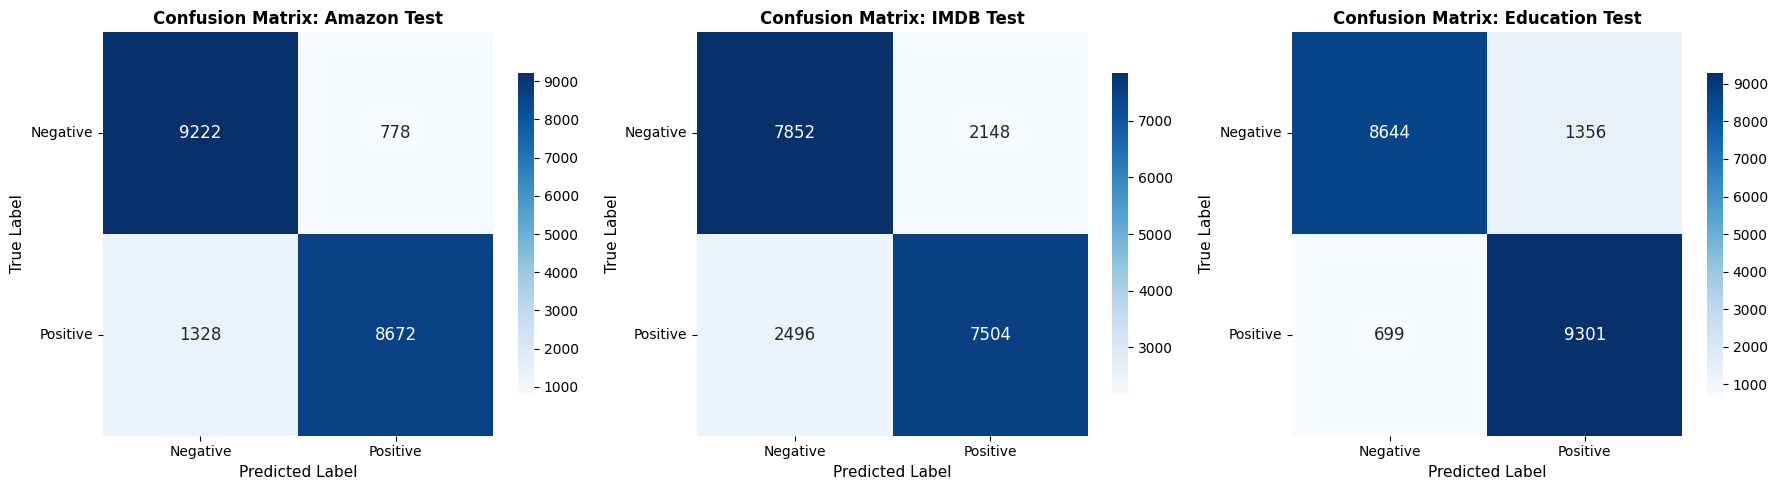

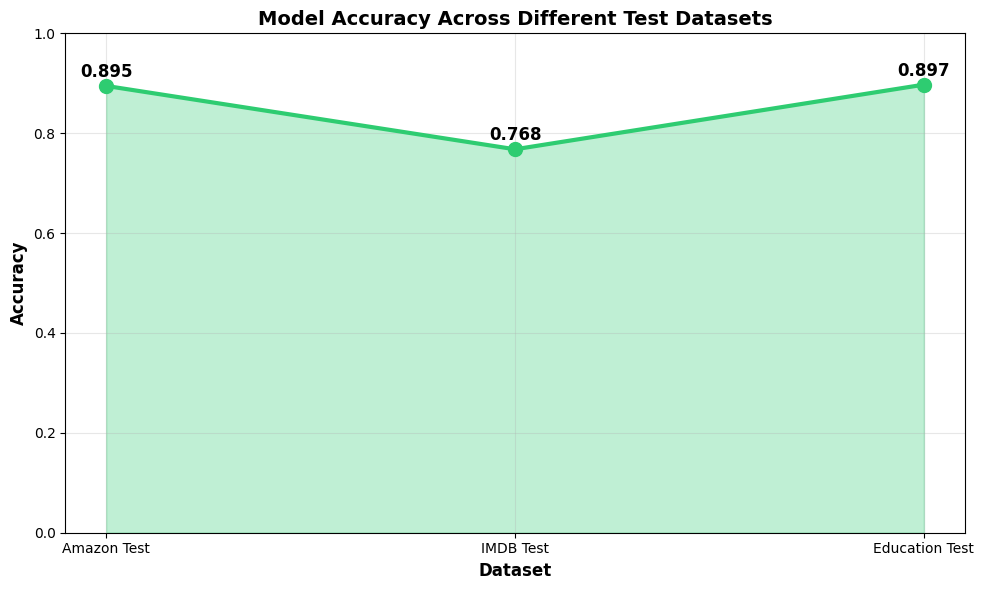

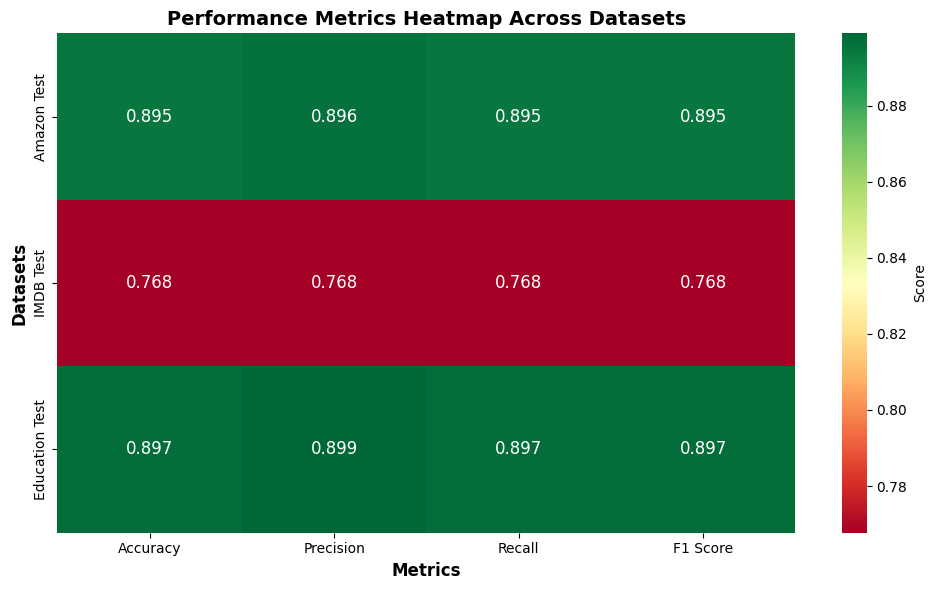


VISUALIZATION COMPLETE
Generated visualizations:
1. Bar chart comparing all metrics across datasets
2. Confusion matrices for all three datasets
3. Accuracy comparison line plot
4. Performance metrics heatmap


In [ ]:
# Cell 23: Proper evaluation with correct data loading and visualization
try:
    # Load test datasets
    print("Loading test datasets...")
    dtest_amazon = load_feature_set("amazon_test")
    dtest_imdb = load_feature_set("imdb_test")
    dtest_edu = load_feature_set("edu_test")

    if None in [dtest_amazon, dtest_imdb, dtest_edu]:
        raise ValueError("Failed to load one or more test datasets")

    # Create data loaders
    test_loaders = {
        'Amazon Test': DataLoader(dtest_amazon, batch_size=32, shuffle=False),
        'IMDB Test': DataLoader(dtest_imdb, batch_size=32, shuffle=False),
        'Education Test': DataLoader(dtest_edu, batch_size=32, shuffle=False)
    }

    # Evaluate on all test sets
    results = {}
    all_conf_matrices = {}

    for name, loader in test_loaders.items():
        print(f"\nEvaluating on {name}...")
        acc, precision, recall, f1, y_true, y_pred = evaluate_model(model, loader)

        results[name] = {
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        all_conf_matrices[name] = confusion_matrix(y_true, y_pred)

        print(f"Results for {name}:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        # Print detailed classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_true, y_pred))

    # Print summary table
    print("\n" + "="*60)
    print("FINAL RESULTS SUMMARY")
    print("="*60)
    print(f"{'Dataset':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-"*60)
    for dataset, metrics in results.items():
        print(f"{dataset:<15} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f} {metrics['Recall']:<10.4f} {metrics['F1 Score']:<10.4f}")


    # 1. Bar chart comparing all metrics across datasets
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.style.use('default')

    # Prepare data for bar chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    datasets = list(results.keys())
    values = np.array([[results[d][m] for m in metrics_names] for d in datasets])

    # Create bar chart
    plt.figure(figsize=(14, 8))
    bar_width = 0.2
    x = np.arange(len(datasets))
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    for i, (metric, color) in enumerate(zip(metrics_names, colors)):
        plt.bar(x + i * bar_width, values[:, i], width=bar_width, label=metric, color=color, alpha=0.8)

    plt.xlabel('Dataset', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('Model Performance Metrics Comparison Across Datasets', fontsize=14, fontweight='bold')
    plt.xticks(x + 1.5 * bar_width, datasets, fontsize=11)
    plt.ylim(0, 1)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (metric, color) in enumerate(zip(metrics_names, colors)):
        for j, value in enumerate(values[:, i]):
            plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 2. Confusion matrices in a single figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (name, cm) in enumerate(all_conf_matrices.items()):
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   cbar_kws={'shrink': 0.8}, annot_kws={'fontsize': 12})
        axes[i].set_title(f'Confusion Matrix: {name}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted Label', fontsize=11)
        axes[i].set_ylabel('True Label', fontsize=11)

        # Add class labels if you know them (assuming binary classification: 0=Negative, 1=Positive)
        class_labels = ['Negative', 'Positive']
        axes[i].set_xticklabels(class_labels, rotation=0)
        axes[i].set_yticklabels(class_labels, rotation=0)

    plt.tight_layout()
    plt.show()

    # 3. Additional visualization: Accuracy comparison line plot
    plt.figure(figsize=(10, 6))
    accuracies = [results[dataset]['Accuracy'] for dataset in datasets]
    plt.plot(datasets, accuracies, marker='o', linewidth=3, markersize=10, color='#2ecc71')
    plt.fill_between(datasets, accuracies, alpha=0.3, color='#2ecc71')

    for i, (dataset, acc) in enumerate(zip(datasets, accuracies)):
        plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    plt.xlabel('Dataset', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Model Accuracy Across Different Test Datasets', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Heatmap of all metrics across datasets
    plt.figure(figsize=(10, 6))

    # Create matrix for heatmap
    metrics_matrix = []
    for dataset in datasets:
        metrics_matrix.append([results[dataset][metric] for metric in metrics_names])

    # Create heatmap
    sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
               xticklabels=metrics_names, yticklabels=datasets,
               cbar_kws={'label': 'Score'}, annot_kws={'fontsize': 12})

    plt.title('Performance Metrics Heatmap Across Datasets', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Datasets', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("VISUALIZATION COMPLETE")
    print("="*60)
    print("Generated visualizations:")
    print("1. Bar chart comparing all metrics across datasets")
    print("2. Confusion matrices for all three datasets")
    print("3. Accuracy comparison line plot")
    print("4. Performance metrics heatmap")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

def k_fold_cross_validation(dataset, model_class, k_folds=10, batch_size=32, epochs=20, lr=2e-4):
    """
    Perform K-Fold Cross-Validation on your feature attention fusion model
    """
    # Initialize KFold
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Storage for results
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Get feature dimensions from dataset
    sample_bert, sample_lex, sample_syn, sample_label = dataset[0]
    dim_bert = sample_bert.shape[0]
    dim_lex = sample_lex.shape[0]
    dim_syn = sample_syn.shape[0]
    num_classes = len(np.unique(dataset.labels))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Starting {k_folds}-Fold Cross-Validation...")

    for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 30)

        # Create data subsets
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = model_class(
            bert_dim=dim_bert,
            lex_dim=dim_lex,
            syn_dim=dim_syn,
            hidden_dim=128,
            num_classes=num_classes
        ).to(device)

        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for bert, lex, syn, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                bert, lex, syn, labels = bert.to(device), lex.to(device), syn.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(bert, lex, syn)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for bert, lex, syn, labels in val_loader:
                bert, lex, syn = bert.to(device), lex.to(device), syn.to(device)
                outputs = model(bert, lex, syn)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['f1'].append(f1)

        print(f"Fold {fold + 1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # Calculate overall results
    print(f"\n{'='*50}")
    print("CROSS-VALIDATION RESULTS")
    print(f"{'='*50}")

    for metric in fold_results:
        values = fold_results[metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

    return fold_results

# Usage with your existing dataset
try:
    # Load your training dataset
    dtrain = load_feature_set("amazon_train")

    # Run K-Fold Cross-Validation
    results = k_fold_cross_validation(
        dataset=dtrain,
        model_class=FeatureAttentionFusionModel,
        k_folds=10,
        batch_size=32,
        epochs=15,  # Reduced for cross-validation
        lr=2e-4
    )

    print("K-Fold Cross-Validation completed successfully!")

except Exception as e:
    print(f"Error during K-Fold validation: {e}")


Starting 10-Fold Cross-Validation...

Fold 1/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.87it/s]


Epoch 5/15, Loss: 0.2663


Epoch 10/15: 100%|██████████| 4500/4500 [00:18<00:00, 240.48it/s]


Epoch 10/15, Loss: 0.2522


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 243.71it/s]


Epoch 15/15, Loss: 0.2420
Fold 1 Results:
Accuracy: 0.8879
Precision: 0.8895
Recall: 0.8879
F1-Score: 0.8879

Fold 2/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:18<00:00, 248.81it/s]


Epoch 5/15, Loss: 0.2678


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.16it/s]


Epoch 10/15, Loss: 0.2536


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 255.75it/s]


Epoch 15/15, Loss: 0.2427
Fold 2 Results:
Accuracy: 0.8944
Precision: 0.8945
Recall: 0.8944
F1-Score: 0.8944

Fold 3/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:18<00:00, 242.67it/s]


Epoch 5/15, Loss: 0.2668


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 251.49it/s]


Epoch 10/15, Loss: 0.2522


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 242.14it/s]


Epoch 15/15, Loss: 0.2431
Fold 3 Results:
Accuracy: 0.8984
Precision: 0.8984
Recall: 0.8984
F1-Score: 0.8984

Fold 4/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:19<00:00, 235.96it/s]


Epoch 5/15, Loss: 0.2684


Epoch 10/15: 100%|██████████| 4500/4500 [00:18<00:00, 241.48it/s]


Epoch 10/15, Loss: 0.2546


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 250.70it/s]


Epoch 15/15, Loss: 0.2442
Fold 4 Results:
Accuracy: 0.8931
Precision: 0.8936
Recall: 0.8931
F1-Score: 0.8931

Fold 5/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:18<00:00, 242.95it/s]


Epoch 5/15, Loss: 0.2657


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 250.36it/s]


Epoch 10/15, Loss: 0.2533


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 251.17it/s]


Epoch 15/15, Loss: 0.2435
Fold 5 Results:
Accuracy: 0.8908
Precision: 0.8919
Recall: 0.8908
F1-Score: 0.8907

Fold 6/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.36it/s]


Epoch 5/15, Loss: 0.2673


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 250.53it/s]


Epoch 10/15, Loss: 0.2548


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 249.19it/s]


Epoch 15/15, Loss: 0.2454
Fold 6 Results:
Accuracy: 0.8949
Precision: 0.8949
Recall: 0.8949
F1-Score: 0.8949

Fold 7/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:18<00:00, 245.97it/s]


Epoch 5/15, Loss: 0.2672


Epoch 10/15: 100%|██████████| 4500/4500 [00:18<00:00, 241.99it/s]


Epoch 10/15, Loss: 0.2527


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.66it/s]


Epoch 15/15, Loss: 0.2440
Fold 7 Results:
Accuracy: 0.8957
Precision: 0.8957
Recall: 0.8957
F1-Score: 0.8957

Fold 8/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:17<00:00, 255.70it/s]


Epoch 5/15, Loss: 0.2670


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 254.38it/s]


Epoch 10/15, Loss: 0.2514


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 248.00it/s]


Epoch 15/15, Loss: 0.2418
Fold 8 Results:
Accuracy: 0.8911
Precision: 0.8913
Recall: 0.8911
F1-Score: 0.8910

Fold 9/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:18<00:00, 247.22it/s]


Epoch 5/15, Loss: 0.2668


Epoch 10/15: 100%|██████████| 4500/4500 [00:18<00:00, 247.64it/s]


Epoch 10/15, Loss: 0.2535


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.25it/s]


Epoch 15/15, Loss: 0.2436
Fold 9 Results:
Accuracy: 0.8974
Precision: 0.8975
Recall: 0.8974
F1-Score: 0.8974

Fold 10/10
------------------------------


Epoch 5/15: 100%|██████████| 4500/4500 [00:17<00:00, 252.22it/s]


Epoch 5/15, Loss: 0.2661


Epoch 10/15: 100%|██████████| 4500/4500 [00:17<00:00, 255.95it/s]


Epoch 10/15, Loss: 0.2545


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 250.73it/s]


Epoch 15/15, Loss: 0.2435
Fold 10 Results:
Accuracy: 0.8932
Precision: 0.8939
Recall: 0.8932
F1-Score: 0.8931

CROSS-VALIDATION RESULTS
Accuracy: 0.8937 ± 0.0030
Precision: 0.8941 ± 0.0026
Recall: 0.8937 ± 0.0030
F1: 0.8937 ± 0.0030
K-Fold Cross-Validation completed successfully!


In [ ]:
from sklearn.model_selection import StratifiedKFold

def stratified_k_fold_cross_validation(dataset, model_class, k_folds=10, batch_size=32, epochs=20, lr=2e-4):
    """
    Perform Stratified K-Fold Cross-Validation ensuring balanced class distribution
    """
    # Extract labels for stratification
    labels = dataset.labels

    # Initialize Stratified KFold
    skfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Storage for results
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'class_distribution': []
    }

    # Get feature dimensions
    sample_bert, sample_lex, sample_syn, sample_label = dataset[0]
    dim_bert = sample_bert.shape[0]
    dim_lex = sample_lex.shape[0]
    dim_syn = sample_syn.shape[0]
    num_classes = len(np.unique(labels))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Starting {k_folds}-Fold Stratified Cross-Validation...")
    print(f"Total samples: {len(dataset)}")
    print(f"Class distribution: {np.bincount(labels)}")

    for fold, (train_indices, val_indices) in enumerate(skfold.split(range(len(dataset)), labels)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 30)

        # Check class distribution in this fold
        train_labels = labels[train_indices]
        val_labels = labels[val_indices]

        train_dist = np.bincount(train_labels, minlength=num_classes)
        val_dist = np.bincount(val_labels, minlength=num_classes)

        print(f"Train set distribution: {train_dist}")
        print(f"Validation set distribution: {val_dist}")
        fold_results['class_distribution'].append((train_dist, val_dist))

        # Create data subsets
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = model_class(
            bert_dim=dim_bert,
            lex_dim=dim_lex,
            syn_dim=dim_syn,
            hidden_dim=128,
            num_classes=num_classes
        ).to(device)

        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop (same as above)
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for bert, lex, syn, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                bert, lex, syn, labels_batch = bert.to(device), lex.to(device), syn.to(device), labels_batch.to(device)

                optimizer.zero_grad()
                outputs = model(bert, lex, syn)
                loss = criterion(outputs, labels_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

        # Evaluation (same as above)
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for bert, lex, syn, labels_batch in val_loader:
                bert, lex, syn = bert.to(device), lex.to(device), syn.to(device)
                outputs = model(bert, lex, syn)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels_batch.numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['f1'].append(f1)

        print(f"Fold {fold + 1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # Calculate overall results
    print(f"\n{'='*50}")
    print("STRATIFIED CROSS-VALIDATION RESULTS")
    print(f"{'='*50}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = fold_results[metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

    return fold_results

# Usage
try:
    dtrain = load_feature_set("amazon_train")

    results = stratified_k_fold_cross_validation(
        dataset=dtrain,
        model_class=FeatureAttentionFusionModel,
        k_folds=10,
        batch_size=32,
        epochs=15,
        lr=2e-4
    )

    print("Stratified K-Fold Cross-Validation completed!")

except Exception as e:
    print(f"Error during Stratified K-Fold validation: {e}")


Starting 10-Fold Stratified Cross-Validation...
Total samples: 160000
Class distribution: [80000 80000]

Fold 1/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 254.38it/s]


Fold 1 Results:
Accuracy: 0.8901
Precision: 0.8910
Recall: 0.8901
F1-Score: 0.8901

Fold 2/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 244.54it/s]


Fold 2 Results:
Accuracy: 0.8886
Precision: 0.8895
Recall: 0.8886
F1-Score: 0.8885

Fold 3/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 255.63it/s]


Fold 3 Results:
Accuracy: 0.8943
Precision: 0.8948
Recall: 0.8943
F1-Score: 0.8943

Fold 4/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 253.14it/s]


Fold 4 Results:
Accuracy: 0.8959
Precision: 0.8966
Recall: 0.8959
F1-Score: 0.8959

Fold 5/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 255.69it/s]


Fold 5 Results:
Accuracy: 0.8934
Precision: 0.8949
Recall: 0.8934
F1-Score: 0.8933

Fold 6/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 251.34it/s]


Fold 6 Results:
Accuracy: 0.8920
Precision: 0.8920
Recall: 0.8920
F1-Score: 0.8920

Fold 7/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 248.38it/s]


Fold 7 Results:
Accuracy: 0.8918
Precision: 0.8919
Recall: 0.8918
F1-Score: 0.8918

Fold 8/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 254.65it/s]


Fold 8 Results:
Accuracy: 0.8912
Precision: 0.8913
Recall: 0.8912
F1-Score: 0.8912

Fold 9/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:18<00:00, 246.67it/s]


Fold 9 Results:
Accuracy: 0.8853
Precision: 0.8896
Recall: 0.8853
F1-Score: 0.8850

Fold 10/10
------------------------------
Train set distribution: [72000 72000]
Validation set distribution: [8000 8000]


Epoch 15/15: 100%|██████████| 4500/4500 [00:17<00:00, 253.51it/s]


Fold 10 Results:
Accuracy: 0.8856
Precision: 0.8892
Recall: 0.8856
F1-Score: 0.8854

STRATIFIED CROSS-VALIDATION RESULTS
Accuracy: 0.8908 ± 0.0033
Precision: 0.8921 ± 0.0024
Recall: 0.8908 ± 0.0033
F1: 0.8907 ± 0.0034
Stratified K-Fold Cross-Validation completed!


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_cross_validation(dataset, model_class, n_splits=10, batch_size=32, epochs=20, lr=2e-4):
    """
    Perform Time-Series Cross-Validation to avoid data leakage
    Assumes your dataset has temporal ordering
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Storage for results
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'train_sizes': [],
        'test_sizes': []
    }

    # Get feature dimensions
    sample_bert, sample_lex, sample_syn, sample_label = dataset[0]
    dim_bert = sample_bert.shape[0]
    dim_lex = sample_lex.shape[0]
    dim_syn = sample_syn.shape[0]
    num_classes = len(np.unique(dataset.labels))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Starting Time-Series Cross-Validation with {n_splits} splits...")
    print(f"Total samples: {len(dataset)}")

    for fold, (train_indices, test_indices) in enumerate(tscv.split(range(len(dataset)))):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 30)
        print(f"Train size: {len(train_indices)}, Test size: {len(test_indices)}")
        print(f"Train indices: {train_indices[0]} to {train_indices[-1]}")
        print(f"Test indices: {test_indices[0]} to {test_indices[-1]}")

        fold_results['train_sizes'].append(len(train_indices))
        fold_results['test_sizes'].append(len(test_indices))

        # Create data subsets
        train_subset = Subset(dataset, train_indices)
        test_subset = Subset(dataset, test_indices)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)  # No shuffle for time series!
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = model_class(
            bert_dim=dim_bert,
            lex_dim=dim_lex,
            syn_dim=dim_syn,
            hidden_dim=128,
            num_classes=num_classes
        ).to(device)

        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for bert, lex, syn, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                bert, lex, syn, labels = bert.to(device), lex.to(device), syn.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(bert, lex, syn)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for bert, lex, syn, labels in test_loader:
                bert, lex, syn = bert.to(device), lex.to(device), syn.to(device)
                outputs = model(bert, lex, syn)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['f1'].append(f1)

        print(f"Fold {fold + 1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # Calculate overall results
    print(f"\n{'='*50}")
    print("TIME-SERIES CROSS-VALIDATION RESULTS")
    print(f"{'='*50}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = fold_results[metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

    return fold_results

# Usage
try:
    dtrain = load_feature_set("amazon_train")

    results = time_series_cross_validation(
        dataset=dtrain,
        model_class=FeatureAttentionFusionModel,
        n_splits=10,
        batch_size=32,
        epochs=15,
        lr=2e-4
    )

    print("Time-Series Cross-Validation completed!")

except Exception as e:
    print(f"Error during Time-Series validation: {e}")


Starting Time-Series Cross-Validation with 10 splits...
Total samples: 160000

Fold 1/10
------------------------------
Train size: 14550, Test size: 14545
Train indices: 0 to 14549
Test indices: 14550 to 29094


Epoch 15/15: 100%|██████████| 455/455 [00:02<00:00, 205.40it/s]


Fold 1 Results:
Accuracy: 0.8716
Precision: 0.8719
Recall: 0.8716
F1-Score: 0.8716

Fold 2/10
------------------------------
Train size: 29095, Test size: 14545
Train indices: 0 to 29094
Test indices: 29095 to 43639


Epoch 15/15: 100%|██████████| 910/910 [00:03<00:00, 234.11it/s]


Fold 2 Results:
Accuracy: 0.8834
Precision: 0.8835
Recall: 0.8834
F1-Score: 0.8834

Fold 3/10
------------------------------
Train size: 43640, Test size: 14545
Train indices: 0 to 43639
Test indices: 43640 to 58184


Epoch 15/15: 100%|██████████| 1364/1364 [00:05<00:00, 248.52it/s]


Fold 3 Results:
Accuracy: 0.8835
Precision: 0.8843
Recall: 0.8835
F1-Score: 0.8835

Fold 4/10
------------------------------
Train size: 58185, Test size: 14545
Train indices: 0 to 58184
Test indices: 58185 to 72729


Epoch 15/15: 100%|██████████| 1819/1819 [00:06<00:00, 263.95it/s]


Fold 4 Results:
Accuracy: 0.8816
Precision: 0.8823
Recall: 0.8816
F1-Score: 0.8815

Fold 5/10
------------------------------
Train size: 72730, Test size: 14545
Train indices: 0 to 72729
Test indices: 72730 to 87274


Epoch 15/15: 100%|██████████| 2273/2273 [00:08<00:00, 273.83it/s]


Fold 5 Results:
Accuracy: 0.8861
Precision: 0.8872
Recall: 0.8861
F1-Score: 0.8860

Fold 6/10
------------------------------
Train size: 87275, Test size: 14545
Train indices: 0 to 87274
Test indices: 87275 to 101819


Epoch 15/15: 100%|██████████| 2728/2728 [00:10<00:00, 251.95it/s]


Fold 6 Results:
Accuracy: 0.8914
Precision: 0.8921
Recall: 0.8914
F1-Score: 0.8914

Fold 7/10
------------------------------
Train size: 101820, Test size: 14545
Train indices: 0 to 101819
Test indices: 101820 to 116364


Epoch 15/15: 100%|██████████| 3182/3182 [00:12<00:00, 255.19it/s]


Fold 7 Results:
Accuracy: 0.8932
Precision: 0.8932
Recall: 0.8932
F1-Score: 0.8932

Fold 8/10
------------------------------
Train size: 116365, Test size: 14545
Train indices: 0 to 116364
Test indices: 116365 to 130909


Epoch 15/15: 100%|██████████| 3637/3637 [00:14<00:00, 253.31it/s]


Fold 8 Results:
Accuracy: 0.8902
Precision: 0.8916
Recall: 0.8902
F1-Score: 0.8901

Fold 9/10
------------------------------
Train size: 130910, Test size: 14545
Train indices: 0 to 130909
Test indices: 130910 to 145454


Epoch 15/15: 100%|██████████| 4091/4091 [00:16<00:00, 246.54it/s]


Fold 9 Results:
Accuracy: 0.8854
Precision: 0.8862
Recall: 0.8854
F1-Score: 0.8853

Fold 10/10
------------------------------
Train size: 145455, Test size: 14545
Train indices: 0 to 145454
Test indices: 145455 to 159999


Epoch 15/15: 100%|██████████| 4546/4546 [00:18<00:00, 246.59it/s]


Fold 10 Results:
Accuracy: 0.8903
Precision: 0.8908
Recall: 0.8903
F1-Score: 0.8903

TIME-SERIES CROSS-VALIDATION RESULTS
Accuracy: 0.8857 ± 0.0060
Precision: 0.8863 ± 0.0060
Recall: 0.8857 ± 0.0060
F1: 0.8856 ± 0.0060
Time-Series Cross-Validation completed!


In [ ]:
def comprehensive_validation_comparison(dataset, model_class):
    """
    Run all three validation methods and compare results
    """
    print("="*60)
    print("COMPREHENSIVE VALIDATION COMPARISON")
    print("="*60)

    validation_methods = {
        'Standard K-Fold': k_fold_cross_validation,
        'Stratified K-Fold': stratified_k_fold_cross_validation,
        'Time-Series': time_series_cross_validation
    }

    all_results = {}

    for method_name, validation_func in validation_methods.items():
        print(f"\n{'='*40}")
        print(f"Running {method_name} Validation")
        print(f"{'='*40}")

        try:
            if method_name == 'Time-Series':
                results = validation_func(dataset, model_class, n_splits=5, epochs=10)  # Fewer splits for demo
            else:
                results = validation_func(dataset, model_class, k_folds=5, epochs=10)  # Fewer folds for demo

            all_results[method_name] = results

        except Exception as e:
            print(f"Error in {method_name}: {e}")
            all_results[method_name] = None

    # Compare results
    print(f"\n{'='*60}")
    print("VALIDATION METHODS COMPARISON")
    print(f"{'='*60}")

    comparison_df = []
    for method, results in all_results.items():
        if results is not None:
            row = {
                'Method': method,
                'Accuracy': f"{np.mean(results['accuracy']):.4f} ± {np.std(results['accuracy']):.4f}",
                'Precision': f"{np.mean(results['precision']):.4f} ± {np.std(results['precision']):.4f}",
                'Recall': f"{np.mean(results['recall']):.4f} ± {np.std(results['recall']):.4f}",
                'F1-Score': f"{np.mean(results['f1']):.4f} ± {np.std(results['f1']):.4f}"
            }
            comparison_df.append(row)

    # Print comparison table
    import pandas as pd
    df = pd.DataFrame(comparison_df)
    print(df.to_string(index=False))

    return all_results

# Run comprehensive comparison
try:
    dtrain = load_feature_set("amazon_train")

    all_validation_results = comprehensive_validation_comparison(
        dataset=dtrain,
        model_class=FeatureAttentionFusionModel
    )

except Exception as e:
    print(f"Error during comprehensive validation: {e}")


COMPREHENSIVE VALIDATION COMPARISON

Running Standard K-Fold Validation
Starting 5-Fold Cross-Validation...

Fold 1/5
------------------------------


Epoch 5/10: 100%|██████████| 4000/4000 [00:15<00:00, 255.20it/s]


Epoch 5/10, Loss: 0.2695


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 255.25it/s]


Epoch 10/10, Loss: 0.2553
Fold 1 Results:
Accuracy: 0.8939
Precision: 0.8940
Recall: 0.8939
F1-Score: 0.8939

Fold 2/5
------------------------------


Epoch 5/10: 100%|██████████| 4000/4000 [00:16<00:00, 245.61it/s]


Epoch 5/10, Loss: 0.2688


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 254.19it/s]


Epoch 10/10, Loss: 0.2539
Fold 2 Results:
Accuracy: 0.8914
Precision: 0.8917
Recall: 0.8914
F1-Score: 0.8914

Fold 3/5
------------------------------


Epoch 5/10: 100%|██████████| 4000/4000 [00:15<00:00, 254.98it/s]


Epoch 5/10, Loss: 0.2691


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 255.27it/s]


Epoch 10/10, Loss: 0.2554
Fold 3 Results:
Accuracy: 0.8898
Precision: 0.8907
Recall: 0.8898
F1-Score: 0.8898

Fold 4/5
------------------------------


Epoch 5/10: 100%|██████████| 4000/4000 [00:15<00:00, 252.62it/s]


Epoch 5/10, Loss: 0.2686


Epoch 10/10: 100%|██████████| 4000/4000 [00:16<00:00, 242.96it/s]


Epoch 10/10, Loss: 0.2529
Fold 4 Results:
Accuracy: 0.8889
Precision: 0.8896
Recall: 0.8889
F1-Score: 0.8888

Fold 5/5
------------------------------


Epoch 5/10: 100%|██████████| 4000/4000 [00:15<00:00, 255.57it/s]


Epoch 5/10, Loss: 0.2681


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 253.71it/s]


Epoch 10/10, Loss: 0.2536
Fold 5 Results:
Accuracy: 0.8910
Precision: 0.8926
Recall: 0.8910
F1-Score: 0.8909

CROSS-VALIDATION RESULTS
Accuracy: 0.8910 ± 0.0017
Precision: 0.8917 ± 0.0015
Recall: 0.8910 ± 0.0017
F1: 0.8910 ± 0.0017

Running Stratified K-Fold Validation
Starting 5-Fold Stratified Cross-Validation...
Total samples: 160000
Class distribution: [80000 80000]

Fold 1/5
------------------------------
Train set distribution: [64000 64000]
Validation set distribution: [16000 16000]


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 256.01it/s]


Fold 1 Results:
Accuracy: 0.8917
Precision: 0.8918
Recall: 0.8917
F1-Score: 0.8917

Fold 2/5
------------------------------
Train set distribution: [64000 64000]
Validation set distribution: [16000 16000]


Epoch 10/10: 100%|██████████| 4000/4000 [00:16<00:00, 249.52it/s]


Fold 2 Results:
Accuracy: 0.8938
Precision: 0.8939
Recall: 0.8938
F1-Score: 0.8938

Fold 3/5
------------------------------
Train set distribution: [64000 64000]
Validation set distribution: [16000 16000]


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 254.87it/s]


Fold 3 Results:
Accuracy: 0.8915
Precision: 0.8921
Recall: 0.8915
F1-Score: 0.8915

Fold 4/5
------------------------------
Train set distribution: [64000 64000]
Validation set distribution: [16000 16000]


Epoch 10/10: 100%|██████████| 4000/4000 [00:15<00:00, 254.53it/s]


Fold 4 Results:
Accuracy: 0.8919
Precision: 0.8921
Recall: 0.8919
F1-Score: 0.8919

Fold 5/5
------------------------------
Train set distribution: [64000 64000]
Validation set distribution: [16000 16000]


Epoch 10/10: 100%|██████████| 4000/4000 [00:16<00:00, 247.06it/s]


Fold 5 Results:
Accuracy: 0.8902
Precision: 0.8916
Recall: 0.8902
F1-Score: 0.8902

STRATIFIED CROSS-VALIDATION RESULTS
Accuracy: 0.8918 ± 0.0011
Precision: 0.8923 ± 0.0008
Recall: 0.8918 ± 0.0011
F1: 0.8918 ± 0.0012

Running Time-Series Validation
Starting Time-Series Cross-Validation with 5 splits...
Total samples: 160000

Fold 1/5
------------------------------
Train size: 26670, Test size: 26666
Train indices: 0 to 26669
Test indices: 26670 to 53335


Epoch 10/10: 100%|██████████| 834/834 [00:03<00:00, 275.82it/s]


Fold 1 Results:
Accuracy: 0.8796
Precision: 0.8804
Recall: 0.8796
F1-Score: 0.8795

Fold 2/5
------------------------------
Train size: 53336, Test size: 26666
Train indices: 0 to 53335
Test indices: 53336 to 80001


Epoch 10/10: 100%|██████████| 1667/1667 [00:06<00:00, 271.10it/s]


Fold 2 Results:
Accuracy: 0.8849
Precision: 0.8858
Recall: 0.8849
F1-Score: 0.8848

Fold 3/5
------------------------------
Train size: 80002, Test size: 26666
Train indices: 0 to 80001
Test indices: 80002 to 106667


Epoch 10/10: 100%|██████████| 2501/2501 [00:09<00:00, 250.57it/s]


Fold 3 Results:
Accuracy: 0.8904
Precision: 0.8905
Recall: 0.8904
F1-Score: 0.8904

Fold 4/5
------------------------------
Train size: 106668, Test size: 26666
Train indices: 0 to 106667
Test indices: 106668 to 133333


Epoch 10/10: 100%|██████████| 3334/3334 [00:13<00:00, 252.85it/s]


Fold 4 Results:
Accuracy: 0.8768
Precision: 0.8862
Recall: 0.8768
F1-Score: 0.8761

Fold 5/5
------------------------------
Train size: 133334, Test size: 26666
Train indices: 0 to 133333
Test indices: 133334 to 159999


Epoch 10/10: 100%|██████████| 4167/4167 [00:16<00:00, 257.85it/s]


Fold 5 Results:
Accuracy: 0.8836
Precision: 0.8836
Recall: 0.8836
F1-Score: 0.8836

TIME-SERIES CROSS-VALIDATION RESULTS
Accuracy: 0.8831 ± 0.0047
Precision: 0.8853 ± 0.0033
Recall: 0.8831 ± 0.0047
F1: 0.8829 ± 0.0049

VALIDATION METHODS COMPARISON
           Method        Accuracy       Precision          Recall        F1-Score
  Standard K-Fold 0.8910 ± 0.0017 0.8917 ± 0.0015 0.8910 ± 0.0017 0.8910 ± 0.0017
Stratified K-Fold 0.8918 ± 0.0011 0.8923 ± 0.0008 0.8918 ± 0.0011 0.8918 ± 0.0012
      Time-Series 0.8831 ± 0.0047 0.8853 ± 0.0033 0.8831 ± 0.0047 0.8829 ± 0.0049
